Make true-colour cutouts from HSC data

In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display.ds9 as ds9
import lsst.afw.display.rgb as afwRgb
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage

%matplotlib inline

In [2]:
import os
butler = dafPersist.Butler(os.path.join(os.environ["SUPRIME_DATA_DIR"],
                                        "rerun", "hsc-1248/20150513"))
skymap = butler.get("deepCoadd_skyMap")

Select the object we want to make a Pretty Picture of

In [7]:
if False:
    ra, dec = 150.5197, 2.26207
elif False:
    ra, dec = 150.5255, 2.2578
elif False:
    ra, dec = 150.4710, 2.1218
else:
    ra, dec = 150.35042, +2.27557
    
raDec = afwCoord.Coord(ra*afwGeom.degrees, dec*afwGeom.degrees)

filters = "grizy"  # filters to process -- we choose our bands when we set B, R, G = ...

Figure out the area we want, and read the data.

For coadds the WCS is the same in all bands, but the code handles the general case

Start by finding the tract and patch

In [28]:
tracts = {}
for tractInfo, patchInfo in skymap.findTractPatchList([raDec]):
    tid = tractInfo.getId()
    tracts[tid] = []

    for pi in patchInfo:
        tracts[tid].append("%d,%d" % pi.getIndex())

Then we can read the desired pixels

(We don't use the butler to get the subimage in case it has a PSF that we can't read)

In [70]:
images = {}
cutoutSize = int(15/0.168)   # pixels

for f in filters:
    filterName = "HSC-%s" % f.upper()

    for tract, patches in tracts.items():
        for patch in patches:
            md = butler.get("deepCoadd_md", immediate=True,
                            tract=tract, patch=patch, filter=filterName)
        wcs = afwImage.makeWcs(md)
        xy = afwGeom.PointI(wcs.skyToPixel(raDec))

        llc = afwGeom.PointI(xy - afwGeom.ExtentI(cutoutSize//2, cutoutSize//2))
        bbox = afwGeom.BoxI(llc, afwGeom.ExtentI(cutoutSize, cutoutSize))

        fileName = butler.get("deepCoadd_filename", immediate=True,
                              tract=tract, patch=patch, filter=filterName)[0]

        md = None
        try:
            images[f] = afwImage.MaskedImageF(fileName, md, bbox, afwImage.PARENT)
            break
        except:
            pass

Generate a RGB images, and optionally write to disk

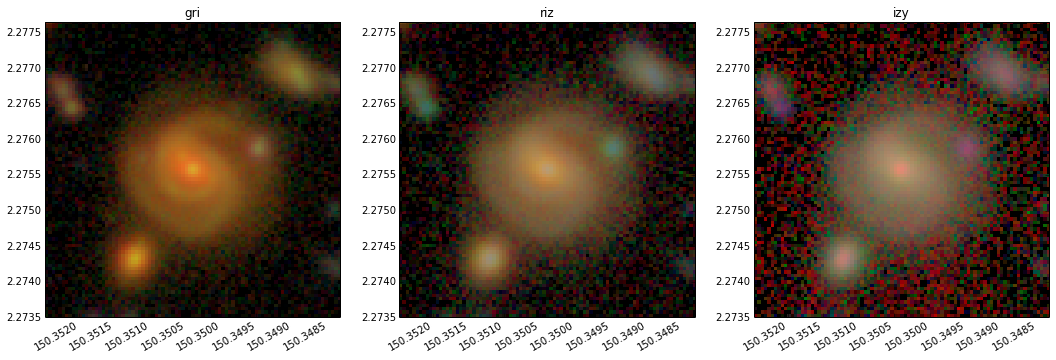

In [84]:
plotRaDec = True

rgbFileFmt = "foo-%s.png" if True else None
min = -0.0
max = 0.4
Q = 12

fig, axes = plt.subplots(ncols=3, figsize=(18, 18))

bbox = images[R].getBBox(afwImage.PARENT)
if plotRaDec:
    raDec0 = [_.asDegrees() for _ in wcs.pixelToSky(*bbox.getBegin())]
    raDec1 = [_.asDegrees() for _ in wcs.pixelToSky(*bbox.getEnd())]

for i, bands in enumerate(["gri", "riz", "izy"]):
    B, G, R = bands
    if True:
        rgb = afwRgb.makeRGB(images[R].getImage(), images[G].getImage(), images[B].getImage(),
                             min, max - min, Q)
    else:        
        #afwRgb.replaceSaturatedPixels(images[R], images[G], images[B], 1, 1e4)

        ims = images[R].getImage(), images[G].getImage(), images[B].getImage()
        rgb = afwRgb.AsinhZScaleMapping(ims, Q=12).makeRgbImage(*ims) #, xSize=1000)
    
    plt = afwRgb.displayRGB(rgb, show=False)
    if plotRaDec:
        title = bands
    else:
        title = "(%.4f, %.4f) %s" % (ra, dec, bands)
    axes[i].set_title(title)
    
    if plotRaDec:
        extent = (raDec0[0], raDec1[0], raDec0[1], raDec1[1])
        formatter = plt.matplotlib.ticker.ScalarFormatter(useOffset=False)
        axes[i].xaxis.set_major_formatter(formatter)
        axes[i].yaxis.set_major_formatter(formatter)

        plt.setp(axes[i].get_xticklabels(), rotation=30, horizontalalignment='right')
    else:
        extent=(bbox.getBeginX(), bbox.getEndX(), bbox.getBeginY(), bbox.getEndY())

    axes[i].imshow(rgb, interpolation='nearest', origin="lower", 
                   aspect='equal', extent=extent)
    
plt.savefig("foo.png", bbox_inches='tight')